In [1]:
from itertools import combinations
import json
import math
import matplotlib as mpl
from matplotlib import colormaps
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import random
import re
import urllib.request

## Fetch data from csv and load into pandas for processing

In [2]:
def get_project_path():
    # Get the path of the project
    path = os.path.join(
            os.getcwd()#path.abspath()   # Path of this file
    )
    return path

In [3]:
def get_data_folder_path():
    path = os.path.join(
        get_project_path(), 
        "data"
    )
    return path

In [4]:
def get_data_file_path(file_name):
    path = os.path.join(
        get_data_folder_path(),
        file_name
    )
    return path

In [5]:
path = get_data_file_path("imdb_top_1000.csv")
path

'/home/aleksandar-lukic/school/02805_Social_Graphs_and_Interactions/Exercise_solutions/Project_assignment/data/imdb_top_1000.csv'

In [6]:
def save_plot_as(folder_path = get_data_folder_path(), file_name = "plot_default", format_name = "png"):
    file_name = file_name + "." + format_name
    file_path = os.path.join(folder_path, file_name)
    plt.savefig(file_path, format = format_name, bbox_inches="tight")

In [7]:
df = pd.read_csv(path)

In [8]:
df = df.drop(["Poster_Link", "Certificate"], axis=1)

In [9]:
# Combine star columns into a single column with a list of actors
df['Actors'] = df[['Star1', 'Star2', 'Star3', 'Star4']].apply(lambda x: list(x), axis=1)

# Drop the individual star columns if they're no longer needed
df = df.drop(columns=['Star1', 'Star2', 'Star3', 'Star4'])

df.head(1)

,Series_Title,Released_Year,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,No_of_Votes,Gross,Actors
0,The Shawshank Redemption,1994,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,2343110,"28,341,469","[Tim Robbins, Morgan Freeman, Bob Gunton, Will..."


In [10]:
header = list(df.columns)
print(len(header))
header

11


['Series_Title',
 'Released_Year',
 'Runtime',
 'Genre',
 'IMDB_Rating',
 'Overview',
 'Meta_score',
 'Director',
 'No_of_Votes',
 'Gross',
 'Actors']

## Extract all movie stars and create nodes based on them

In [11]:
# Get unique Actors from "Star"-columns
set_actors = set(actor for actors_list in df['Actors'] for actor in actors_list)

In [12]:
# Create a NetworkX graph
G = nx.Graph()

In [13]:
# Iterate over each movie 
for row in df.itertuples(index=False):
    
    # Iterate over each actor staring in the movie
    for pair in combinations(row.Actors, 2):
        G.add_edge(pair[0], pair[1])

In [14]:
print("Nodes:", len(G.nodes()))
print("Edges:", len(G.edges()))

Nodes: 2709
Edges: 5837


In [15]:
# Print example edge data
print(*list(G.edges())[:10], sep="\n")

('Tim Robbins', 'Morgan Freeman')
('Tim Robbins', 'Bob Gunton')
('Tim Robbins', 'William Sadler')
('Tim Robbins', 'Sean Penn')
('Tim Robbins', 'Kevin Bacon')
('Tim Robbins', 'Emmy Rossum')
('Tim Robbins', 'Andie MacDowell')
('Tim Robbins', 'Julianne Moore')
('Tim Robbins', 'Bruce Davison')
('Tim Robbins', 'Mark Ruffalo')


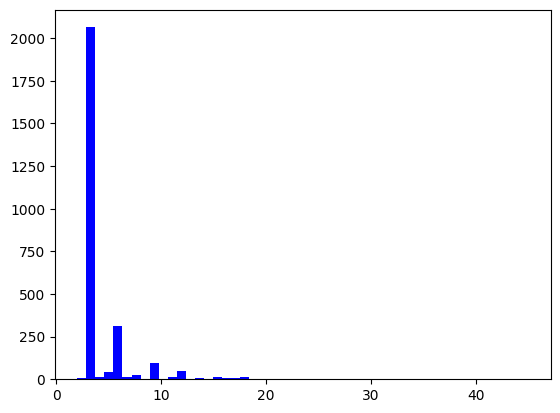

In [16]:
# sort nodes after degree
G_sorted_degree = sorted(G.degree, key=lambda x: x[1], reverse=True)

G_degree_values = [x[1] for x in G_sorted_degree]

# Histogram of In-degree Distribution
plt.hist(
    G_degree_values, 
    bins=50, 
    alpha=1, 
    color="blue"
)
plt.show()

In [17]:
set_degrees = {deg: G_degree_values.count(deg) for deg in set(G_degree_values)}
set_degrees

{2: 7,
 3: 2064,
 4: 12,
 5: 45,
 6: 310,
 7: 12,
 8: 27,
 9: 95,
 10: 3,
 11: 14,
 12: 47,
 13: 2,
 14: 10,
 15: 12,
 16: 5,
 17: 5,
 18: 14,
 19: 1,
 20: 4,
 21: 4,
 23: 2,
 25: 3,
 27: 2,
 30: 1,
 31: 2,
 32: 1,
 33: 1,
 35: 1,
 36: 1,
 38: 1,
 45: 1}

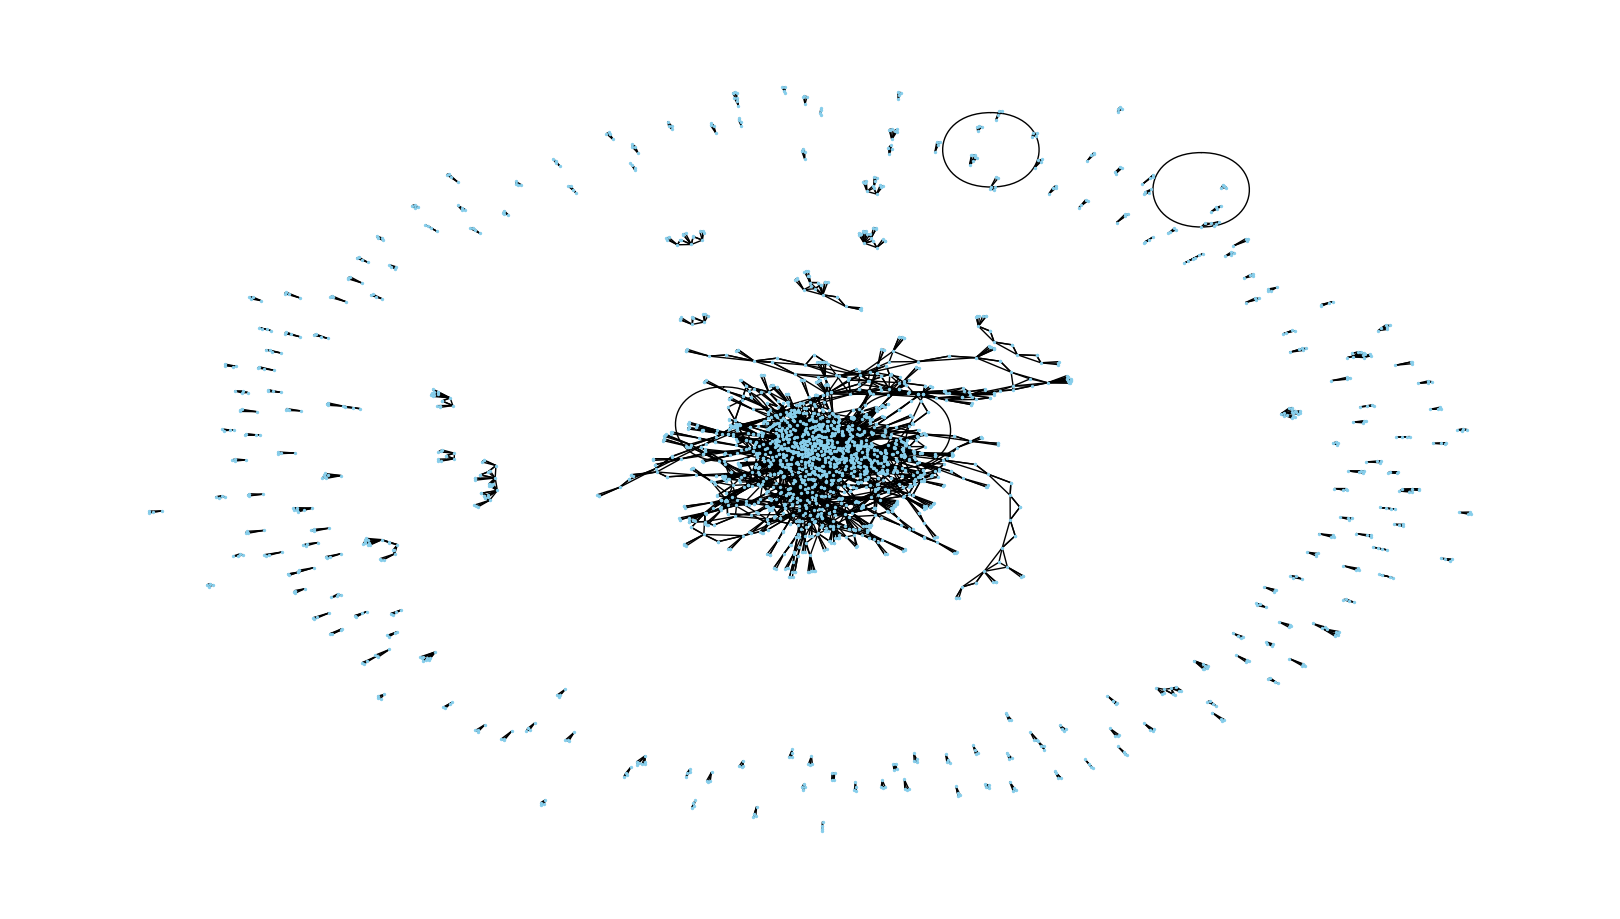

In [18]:
# Visualize the graph
plt.figure(figsize=(16, 9))

pos = nx.spring_layout(G)

nx.draw(
    G, 
    pos, 
    node_color="skyblue",
    node_size=2,
    width=1,
    edge_color="black",
    with_labels=False
)

save_plot_as(file_name="Actors_network_raw", format_name="pdf")
save_plot_as(file_name="Actors_network_raw", format_name="png")

plt.show()

## Update graph to only hold connected component subgraph

In [19]:
# Extract the largest connected component
largest_cc = max(nx.connected_components(G), key=len)

# Create new graph from largest connected component
H = G.subgraph(largest_cc).copy()

In [20]:
# Remove self-loops in order to make the final plot prettier.
H.remove_edges_from(list(nx.selfloop_edges(H)))

In [21]:
print("Nodes:", len(H.nodes()))
print("Edges:", len(H.edges()))

Nodes: 1724
Edges: 4228


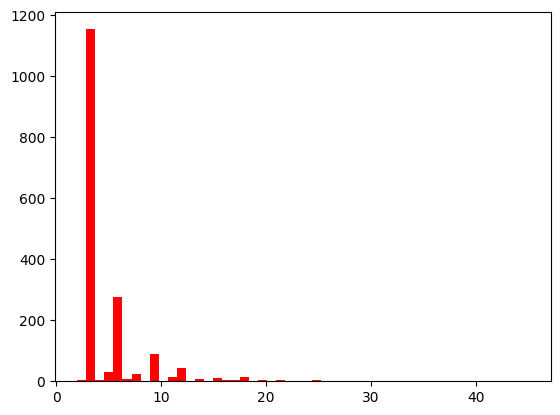

In [22]:
# sort nodes after degree
H_sorted_degree = sorted(H.degree, key=lambda x: x[1], reverse=True)

H_degree_values = [x[1] for x in H_sorted_degree]

# Histogram of In-degree Distribution
plt.hist(
    H_degree_values, 
    bins=50, 
    alpha=1, 
    color="red"
)
plt.show()

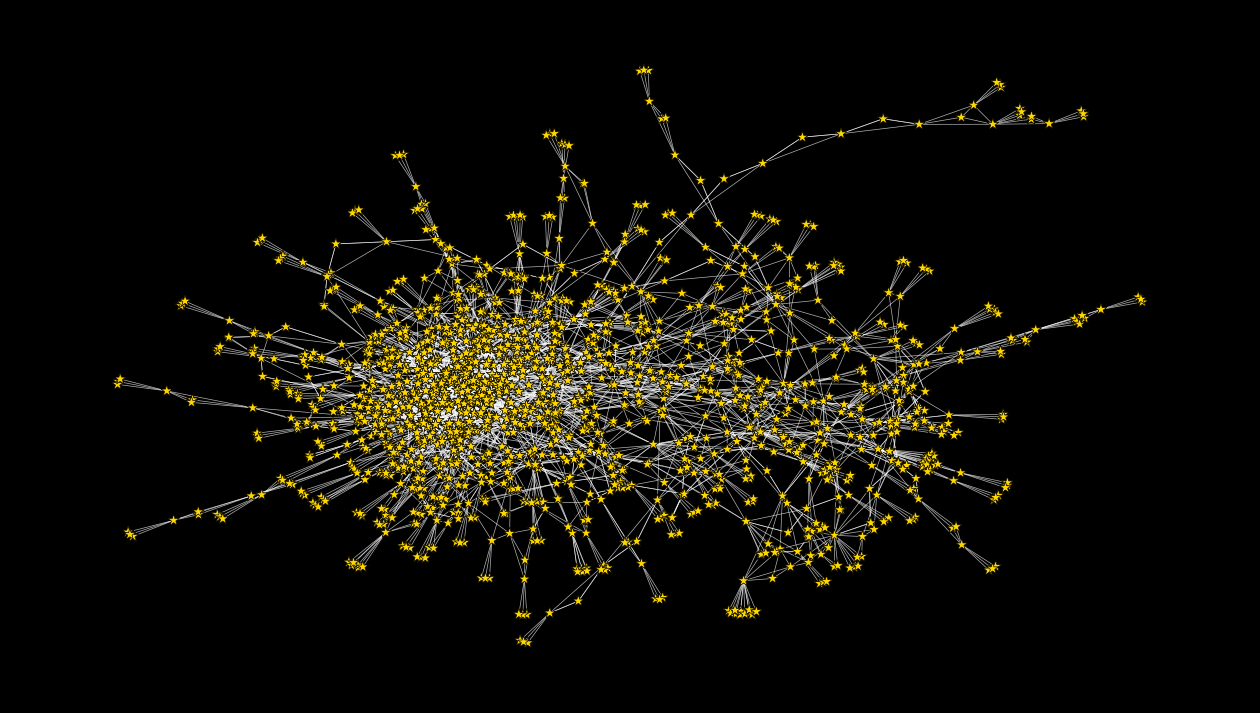

In [23]:
# Visualize the graph
fig, ax = plt.subplots(figsize=(16, 9))

pos = nx.spring_layout(H, seed = 3)

# Draw the nodes without path effects
nodes = nx.draw_networkx_nodes(
    H,
    pos,
    node_shape='*',
    node_size=75,
    node_color='gold',
    edgecolors='black',  # Add a black edge color for the outline
    linewidths=0.5,      # Control the outline thickness
    ax=ax,
)

# Add the stroke effect to the entire node collection
nodes.set_path_effects([
    pe.Stroke(linewidth=0.3, foreground="black"),  # Add black outline
    pe.Normal(),                                  # Normal rendering
])

# Draw the edges
nx.draw_networkx_edges(
    H,
    pos,
    edge_color='white',
    width=0.5,
    alpha=0.7
)

ax.set_facecolor('black')
ax.axis('off')
fig.set_facecolor('black')

save_plot_as(file_name="Actors_network_clean", format_name="pdf")
save_plot_as(file_name="Actors_network_clean", format_name="png")

plt.show()